In [1]:
from astropy.modeling import models, Fittable1DModel, Parameter
from astropy.modeling import fitting
import astropy.units as u
import astropy.constants as const

from spectacle.core.spectrum import Spectrum1D
from spectacle.modeling.custom import Masker
from spectacle.io.registries import line_registry

import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
# plt.rcParams["figure.figsize"] = [8, 16]
# plt.rcParams["figure.dpi"] = 80

# Masking

In [3]:
from astropy.modeling.fitting import LevMarLSQFitter
import astropy.units as u

Define both the wavelength and velocity dispersion arrays. These can be swapped out at will, and the package should automatically adjust as long as they are `Quantity` objects.

In [4]:
wavelength = np.linspace(3500, 3800, 1000) * u.Angstrom
velocity = np.linspace(-800, 800, 1000) * u.Unit("km/s")

Intentionally use the wrong line name to test the word-guessing algorithm.

In [5]:
line = line_registry.with_name('HI1215')
print(line)

INFO:root:Found line with name 'HI1216' from given name 'HI1215'.


 name     wave   osc_str    gamma   
        Angstrom                    
------ --------- ------- -----------
HI1216 1215.6701  0.4164 626500000.0


Create a spectrum object. Note that the the `add_line` method uses the `line_registry`
to find the line information, hence we don't actually *need* to get the line directly
from the registry as we did a couple of lines up.

In [6]:
spectrum = Spectrum1D(center=line['wave'], redshift=2)
spectrum.add_line(name="HI1216", 
                  v_doppler=1e6 * u.Unit('cm/s'),
                  column_density=1e15 * u.Unit('1/cm2'))

INFO:root:Default continuum set to a Linear1D model.


This is the raw spectrum data given the velocity as the dispersion.

In [7]:
y = spectrum.optical_depth(wavelength)
print(spectrum.optical_depth)

Model: BaseSpectrumModel
Name: OpticalDepth
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] | [1] | [2] | [3]
Components: 
    [0]: <DispersionConvert(center=1215.6701 Angstrom)>

    [1]: <Redshift(z=-0.6666666666666667)>

    [2]: <TauProfile(lambda_0=1215.6701 Angstrom, f_value=0.4164, gamma=626500000.0, v_doppler=1000000.0 cm / s, column_density=1000000000000000.0 1 / cm2, delta_v=0.0 cm / s, delta_lambda=0.0 Angstrom, name='HI1216')>

    [3]: <SmartScale(factor=1.0)>
Parameters:
     center_0       z_1       lambda_0_2 ... delta_v_2 delta_lambda_2 factor_3
     Angstrom                  Angstrom  ...   cm / s     Angstrom            
    --------- --------------- ---------- ... --------- -------------- --------
    1215.6701 -0.666666666667  1215.6701 ...       0.0            0.0      1.0


We can mask only the interesting parts by passing the dispersion and data arrays
through the `Masker` model.

In [8]:
# x, my = Masker()(velocity, y)

<IPython.core.display.Javascript object>


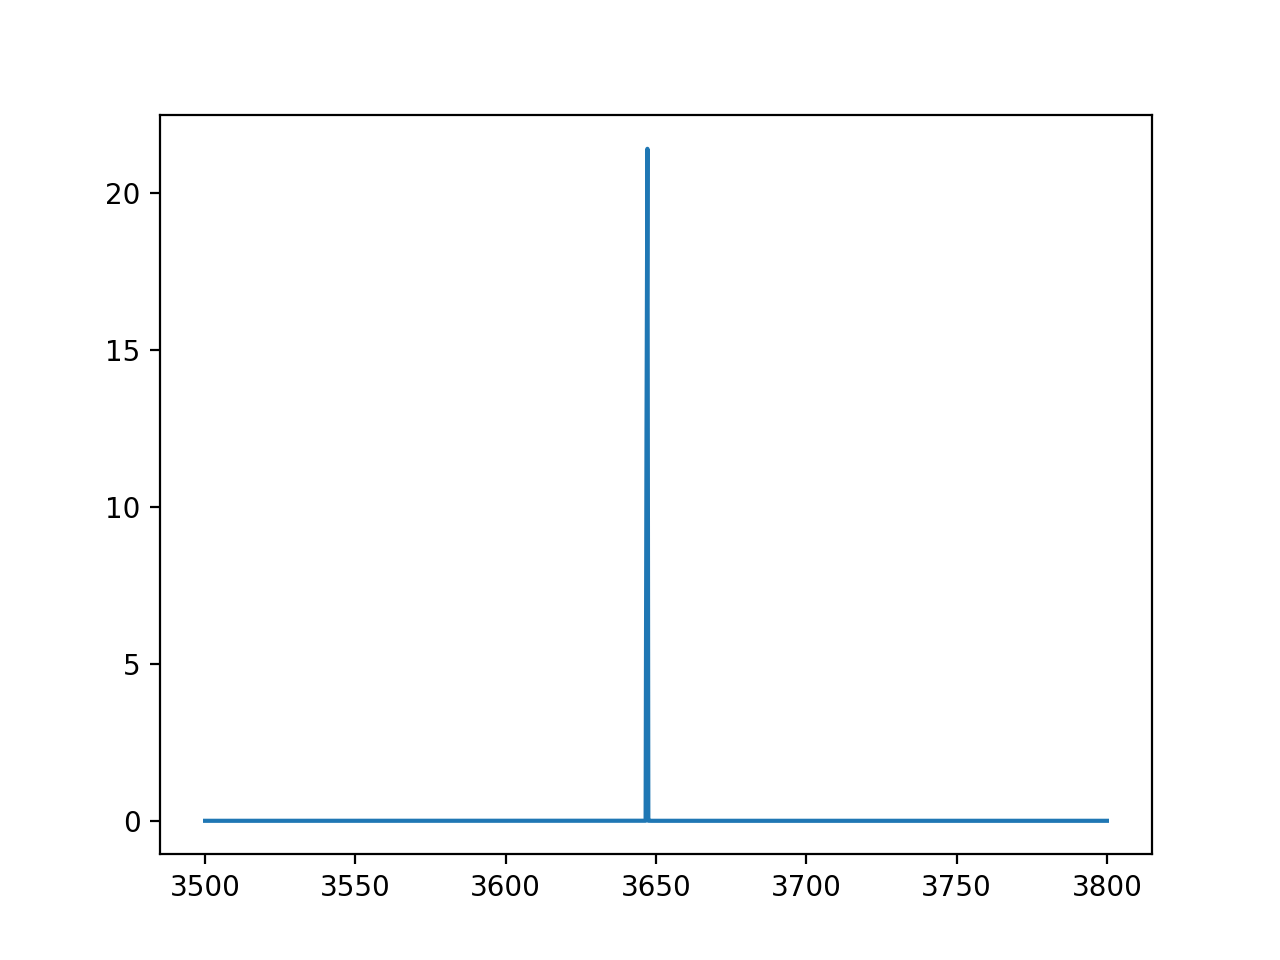

In [9]:
f, ax = plt.subplots()

# ax.plot(velocity, y)
ax.plot(wavelength, y)

## Control Spectrum

This spectrum acts as the standard to which the dynamic spectrum will be compared in the correlation metrics.

In [10]:
import astropy.units as u

wavelength = np.linspace(1200, 1235, 1000) * u.Angstrom
velocity = np.linspace(-800, 800, 1000) * u.Unit("km/s")

INFO:root:Found line with name 'HI1216' from given name 'hi1215'.
INFO:root:Default continuum set to a Linear1D model.
INFO:root:Found line with name 'HI1216' from given name 'hi1215'.
INFO:root:Default continuum set to a Linear1D model.


Model: BaseSpectrumModel
Name: OpticalDepth
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] | [1] | [2] + [3] | [4]
Components: 
    [0]: <DispersionConvert(center=1215.6701 Angstrom)>

    [1]: <Redshift(z=0.0)>

    [2]: <TauProfile(lambda_0=1215.6701 Angstrom, f_value=0.4164, gamma=626500000.0, v_doppler=10000000.0 cm / s, column_density=10000000000000.0 1 / cm2, delta_v=0.0 cm / s, delta_lambda=0.0 Angstrom, name='HI1216')>

    [3]: <TauProfile(lambda_0=1215.6701 Angstrom, f_value=0.4164, gamma=626500000.0, v_doppler=13000000.0 cm / s, column_density=10000000000000.0 1 / cm2, delta_v=0.0 cm / s, delta_lambda=10.0 Angstrom, name='HI1216')>

    [4]: <SmartScale(factor=1.0)>
Parameters:
     center_0 z_1 lambda_0_2 f_value_2 ...   delta_v_3    delta_lambda_3 factor_4
     Angstrom      Angstrom            ...     cm / s        Angstrom            
    --------- --- ---------- --------- ... -------------- -------------- --------
    1215.6701 0.0  1215.6701    0.4164

<IPython.core.display.Javascript object>


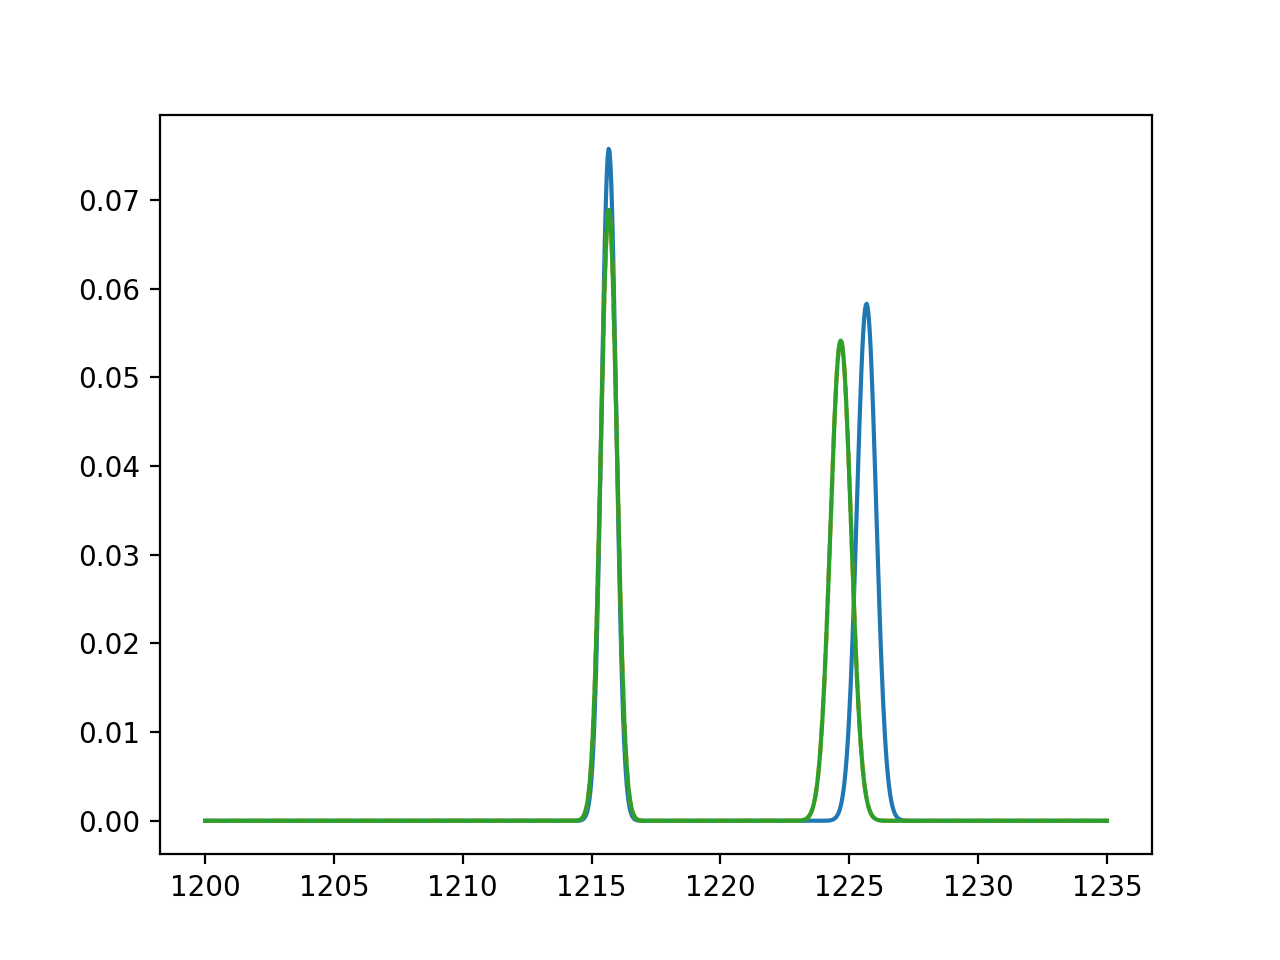

In [11]:
from astropy.modeling.fitting import LevMarLSQFitter

spectrum = Spectrum1D(ion='hi1215', redshift=0.0) \
    .add_line(v_doppler=1e7 * u.Unit('cm/s')) \
    .add_line(v_doppler=1.3e7 * u.Unit('cm/s'), delta_lambda=10 * u.Unit('Angstrom'))
    
y = Spectrum1D(ion='hi1215', redshift=0.0) \
    .add_line(v_doppler=1.1e7 * u.Unit('cm/s')) \
    .add_line(v_doppler=1.4e7 * u.Unit('cm/s'), delta_lambda=9 * u.Unit('Angstrom')) \
    .optical_depth(wavelength)

fitter = LevMarLSQFitter()
new_spec = fitter(spectrum.optical_depth, wavelength, y)

print(new_spec)

f, ax = plt.subplots()

ax.plot(wavelength, spectrum.optical_depth(wavelength))
ax.plot(wavelength, y, ls='--')
ax.plot(wavelength, new_spec(wavelength))

INFO:root:Found line with name 'HI1216' from given name 'HI1215'.
INFO:root:Found line with name 'HI1216' from given name 'hi1215'.
INFO:root:Default continuum set to a Linear1D model.
INFO:root:Found line with name 'HI1216' from given name 'hi1215'.
INFO:root:Default continuum set to a Linear1D model.


<IPython.core.display.Javascript object>


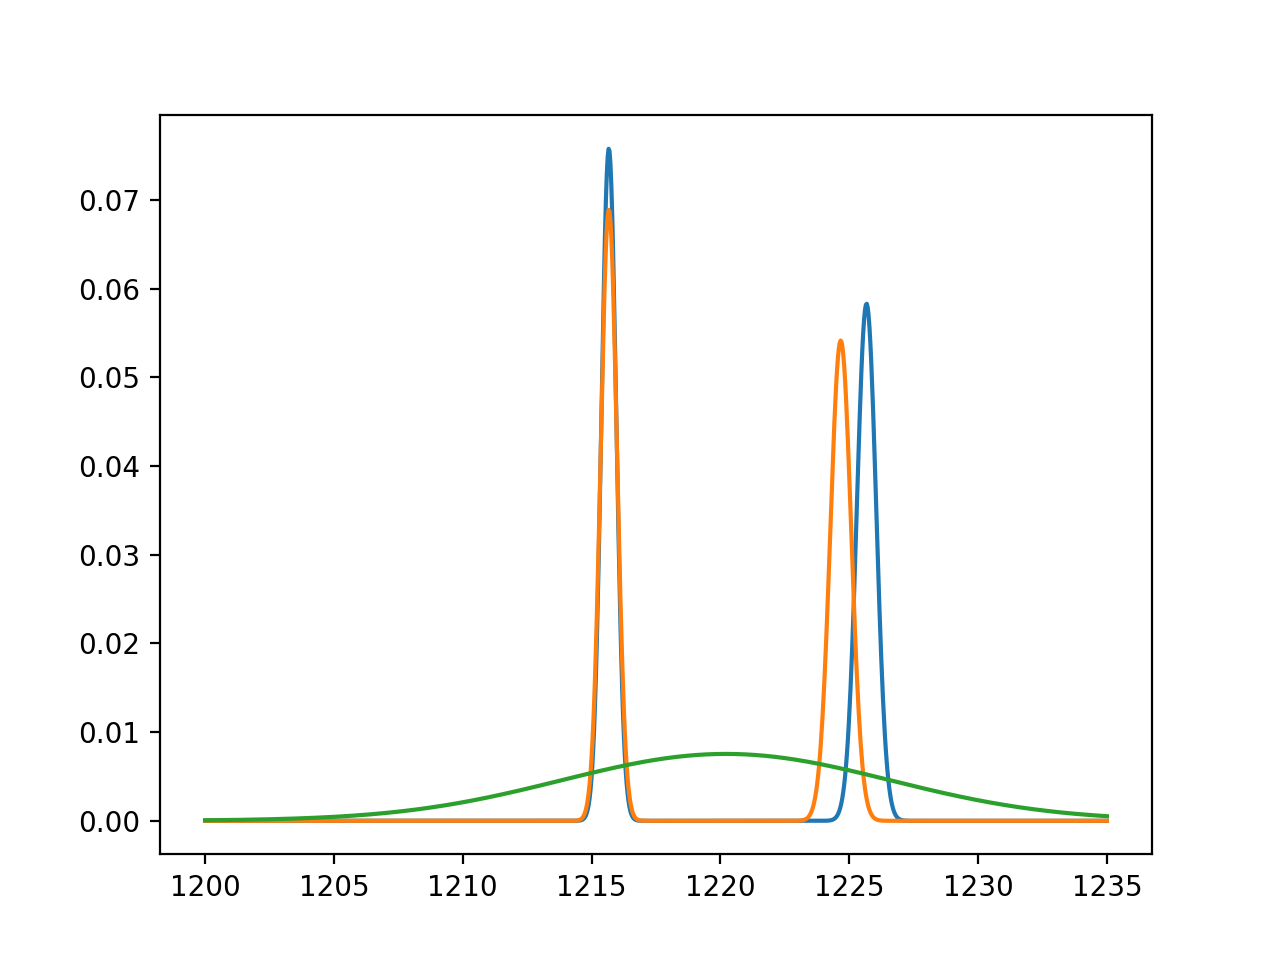

In [12]:
from astropy.modeling.models import Voigt1D
from astropy.modeling.fitting import LevMarLSQFitter

line = line_registry.with_name('HI1215')

spectrum = Spectrum1D(ion='hi1215', redshift=0.0) \
    .add_line(v_doppler=1e7 * u.Unit('cm/s')) \
    .add_line(v_doppler=1.3e7 * u.Unit('cm/s'), delta_lambda=10 * u.Unit('Angstrom'))
    
y = Spectrum1D(ion='hi1215', redshift=0.0) \
    .add_line(v_doppler=1.1e7 * u.Unit('cm/s')) \
    .add_line(v_doppler=1.4e7 * u.Unit('cm/s'), delta_lambda=9 * u.Unit('Angstrom')) \
    .optical_depth(wavelength)
    
voigt = Voigt1D(x_0=1215, amplitude_L=0.17, fwhm_G=40, fwhm_L=8)

fitter = LevMarLSQFitter()
new_voigt = fitter(voigt, wavelength.value, y)

f, ax = plt.subplots()

ax.plot(wavelength, spectrum.optical_depth(wavelength))
ax.plot(wavelength, y)
ax.plot(wavelength, new_voigt(wavelength.value))

# fwhm = line.fwhm(velocity, velocity=True)
# print(fwhm)

# ax.axvline(line['lambda_0']-fwhm*0.5)
# ax.axvline(line['lambda_0']+fwhm*0.5)

# ax.axvline(line['lambda_0']-fwhm)
# ax.axvline(line['lambda_0']+fwhm)

# mask = spectrum.line_mask(velocity)
# ax.scatter(velocity[mask], spectrum.tau.velocity_space(velocity, center=line['lambda_0'])[mask])

# for line in spectrum._line_model:
#     print(line.dv90(wavelength))

In [13]:
# ax.axvline(vmn.value)
# ax.axvline(vmx.value)

In [14]:
# fwhm = spectrum._line_model.fwhm().value
# ax.axvline(-fwhm*0.5, color='r')
# ax.axvline(fwhm*0.5, color='r')

INFO:root:Default continuum set to a Linear1D model.


1215.6701 Angstrom
Found 2 lines.
Found line at 1215.6606605873662 Angstrom (1215.6701 Angstrom with shift of -0.009439412633810207 Angstrom).
[('x_0', 1215.6700999333063), ('amplitude_L', 7.4967540373673422), ('fwhm_L', 0.0046368212190038543), ('fwhm_G', 0.67216321164026038)]
1.50650909965 14.9935080747
Found line at 1225.5989206210306 Angstrom (1215.6701 Angstrom with shift of 9.928820621030582 Angstrom).
[('x_0', 1215.6700999333063), ('amplitude_L', 7.4967540373673422), ('fwhm_L', 0.0046368212190038543), ('fwhm_G', 0.67216321164026038)]
1.50650909965 14.9935080747


<IPython.core.display.Javascript object>


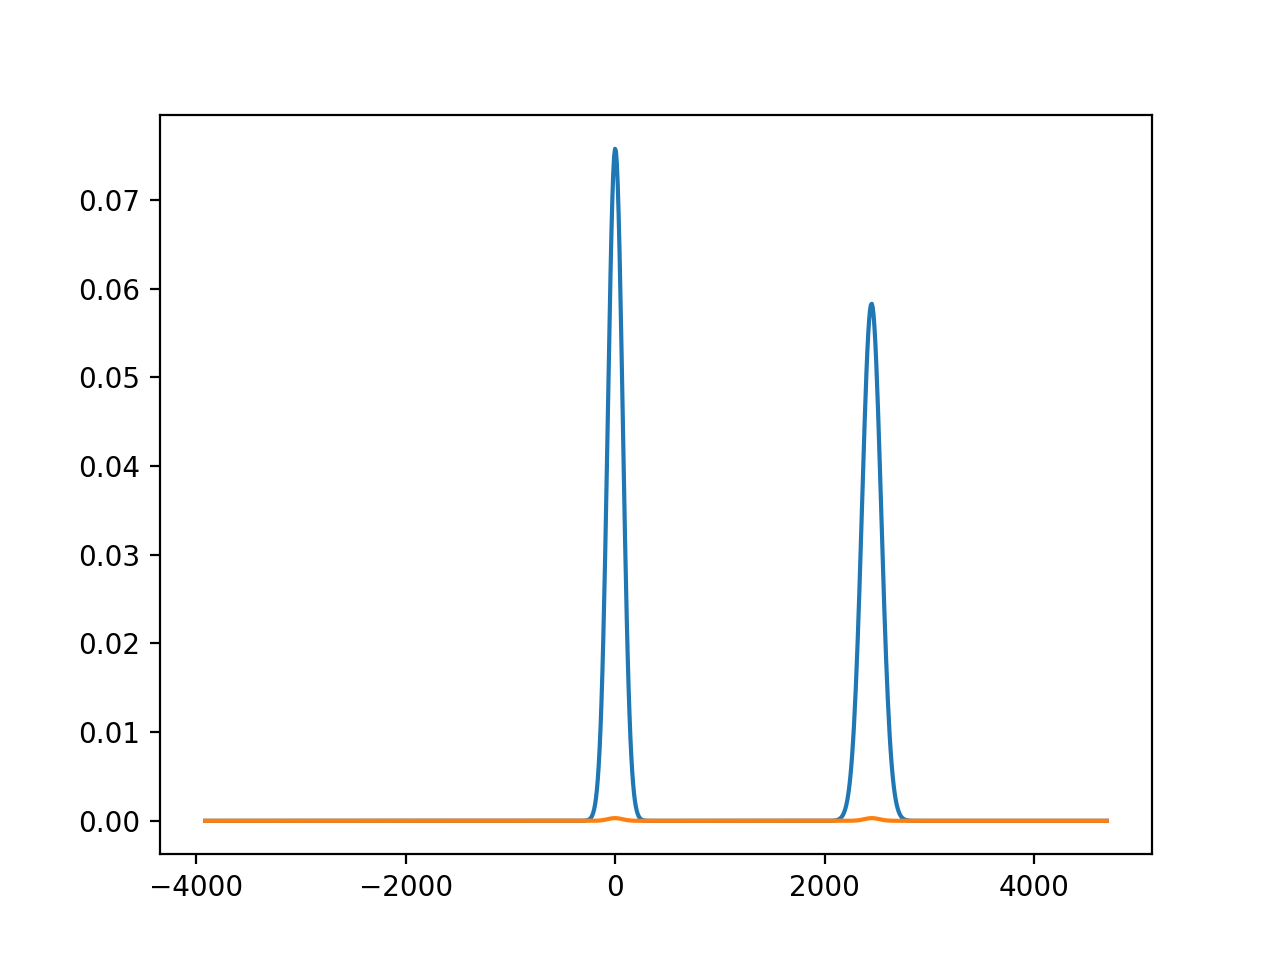

INFO:root:Default continuum set to a Linear1D model.


1215.6701 Angstrom
Found 2 lines.
Found line at 1215.6606605873662 Angstrom (1215.6701 Angstrom with shift of -0.009439412633810207 Angstrom).
[('x_0', 1215.6700999333063), ('amplitude_L', 7.4967540373673422), ('fwhm_L', 0.0046368212190038543), ('fwhm_G', 0.67216321164026038)]
1.50650909965 14.9935080747
Found line at 1225.5989206210306 Angstrom (1215.6701 Angstrom with shift of 9.928820621030582 Angstrom).
[('x_0', 1215.6700999333063), ('amplitude_L', 7.4967540373673422), ('fwhm_L', 0.0046368212190038543), ('fwhm_G', 0.67216321164026038)]
1.50650909965 14.9935080747


<IPython.core.display.Javascript object>


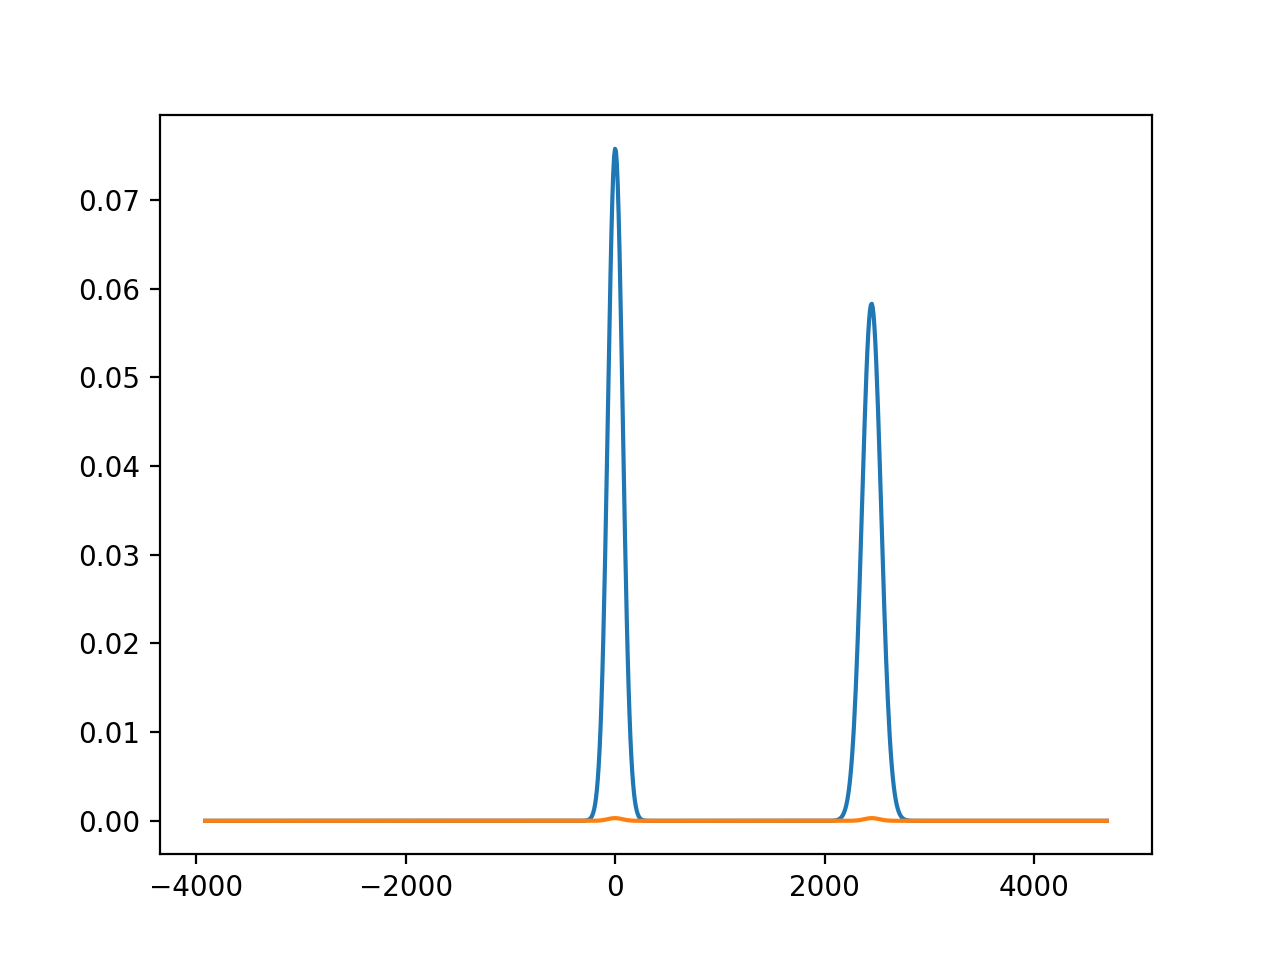

INFO:root:Default continuum set to a Linear1D model.


1215.6701 Angstrom
Found 2 lines.
Found line at 1215.6606605873662 Angstrom (1215.6701 Angstrom with shift of -0.009439412633810207 Angstrom).
[('x_0', 1215.6700999333063), ('amplitude_L', 7.4967540373673422), ('fwhm_L', 0.0046368212190038543), ('fwhm_G', 0.67216321164026038)]
1.50650909965 14.9935080747
Found line at 1225.5989206210306 Angstrom (1215.6701 Angstrom with shift of 9.928820621030582 Angstrom).
[('x_0', 1215.6700999333063), ('amplitude_L', 7.4967540373673422), ('fwhm_L', 0.0046368212190038543), ('fwhm_G', 0.67216321164026038)]
1.50650909965 14.9935080747


<IPython.core.display.Javascript object>


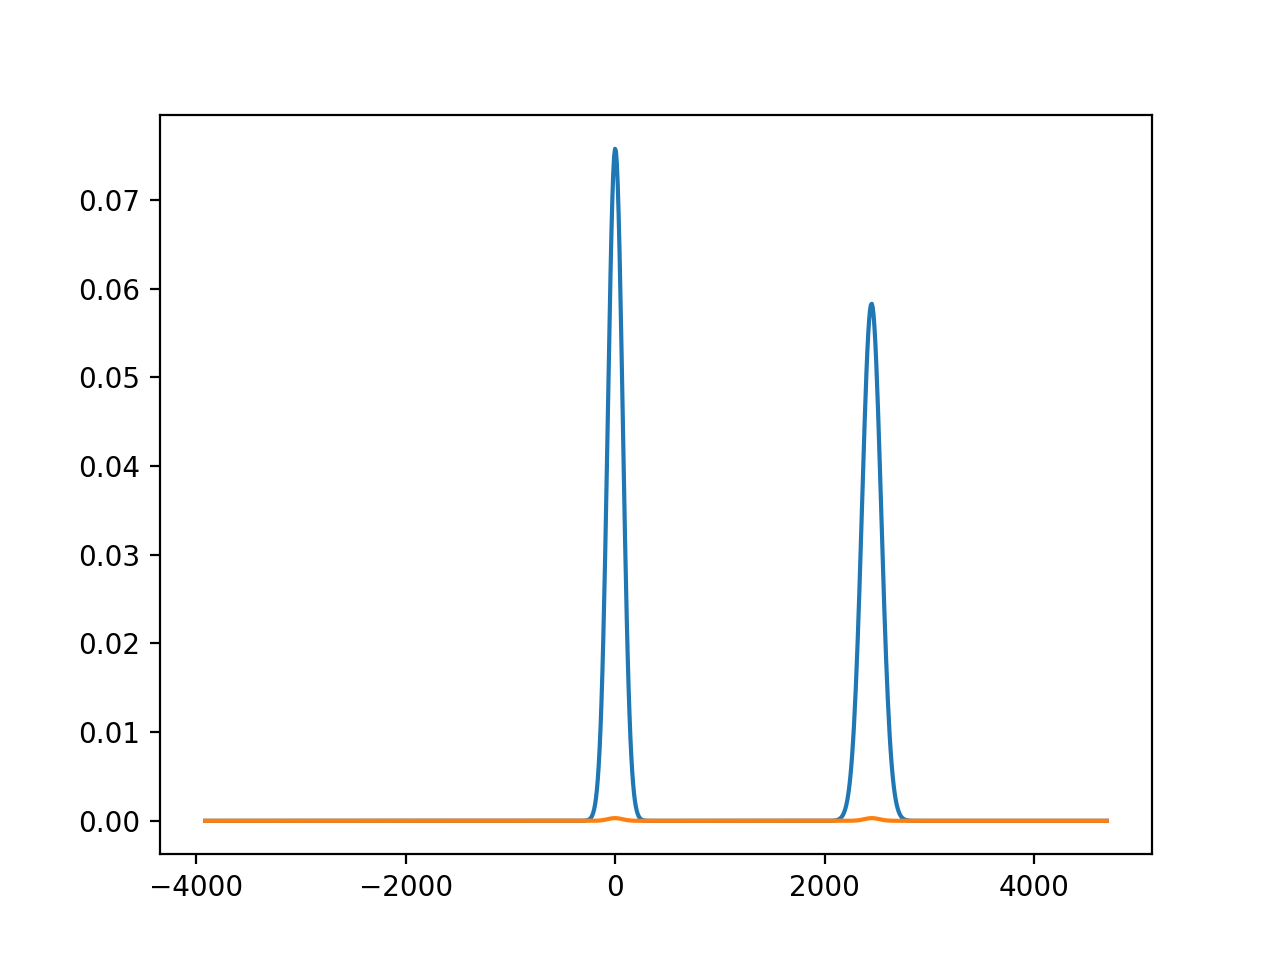

INFO:root:Default continuum set to a Linear1D model.


1215.6701 Angstrom
Found 2 lines.
Found line at 1215.6606605873662 Angstrom (1215.6701 Angstrom with shift of -0.009439412633810207 Angstrom).
[('x_0', 1215.6700999333063), ('amplitude_L', 7.4967540373673422), ('fwhm_L', 0.0046368212190038543), ('fwhm_G', 0.67216321164026038)]
1.50650909965 14.9935080747
Found line at 1225.5989206210306 Angstrom (1215.6701 Angstrom with shift of 9.928820621030582 Angstrom).
[('x_0', 1215.6700999333063), ('amplitude_L', 7.4967540373673422), ('fwhm_L', 0.0046368212190038543), ('fwhm_G', 0.67216321164026038)]
1.50650909965 14.9935080747


<IPython.core.display.Javascript object>


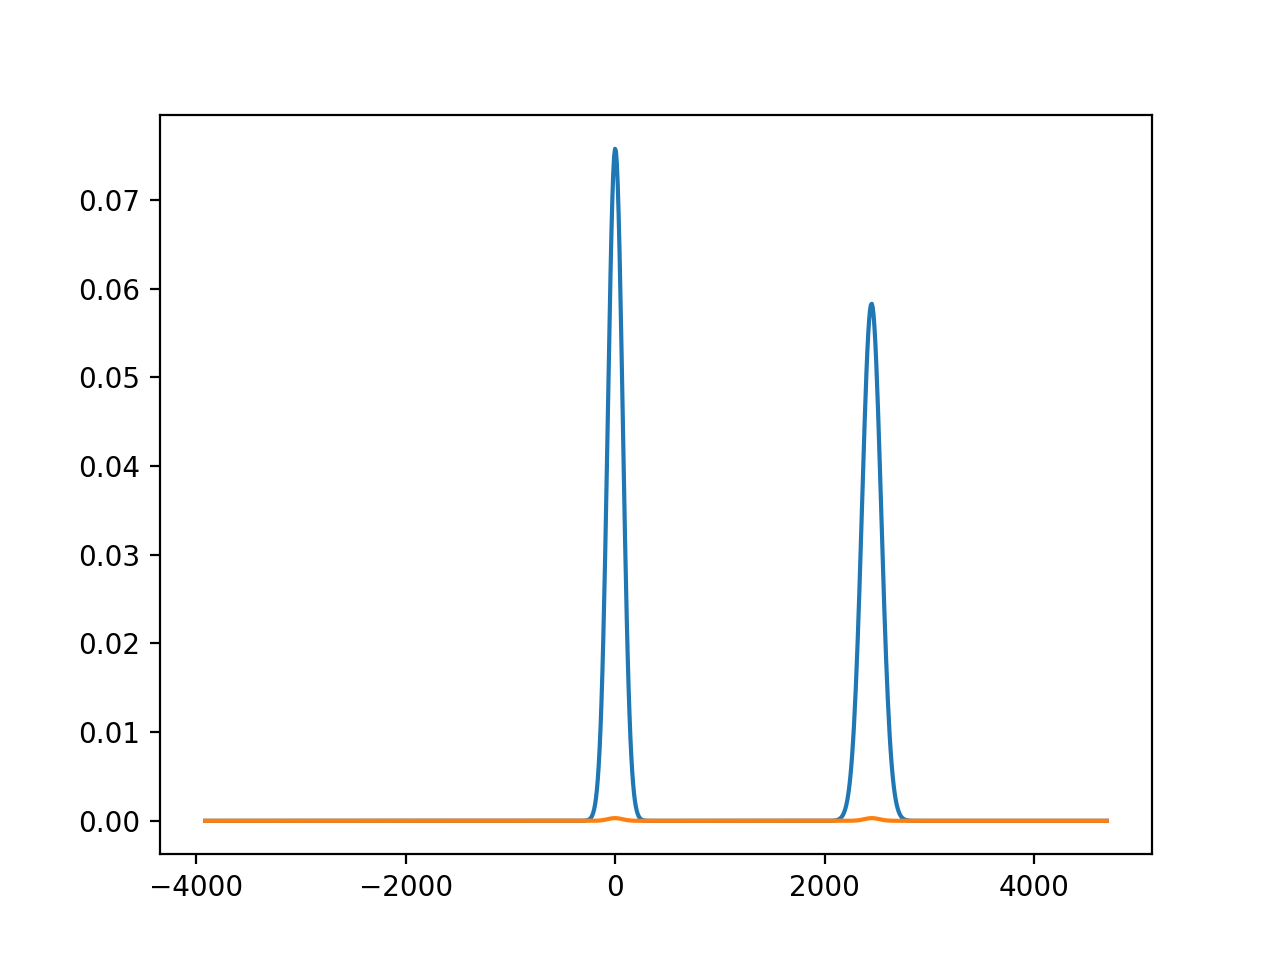

INFO:root:Default continuum set to a Linear1D model.


1215.6701 Angstrom
Found 2 lines.
Found line at 1215.6606605873662 Angstrom (1215.6701 Angstrom with shift of -0.009439412633810207 Angstrom).
[('x_0', 1215.6700999333063), ('amplitude_L', 7.4967540373673422), ('fwhm_L', 0.0046368212190038543), ('fwhm_G', 0.67216321164026038)]
1.50650909965 14.9935080747
Found line at 1225.5989206210306 Angstrom (1215.6701 Angstrom with shift of 9.928820621030582 Angstrom).
[('x_0', 1215.6700999333063), ('amplitude_L', 7.4967540373673422), ('fwhm_L', 0.0046368212190038543), ('fwhm_G', 0.67216321164026038)]
1.50650909965 14.9935080747


<IPython.core.display.Javascript object>


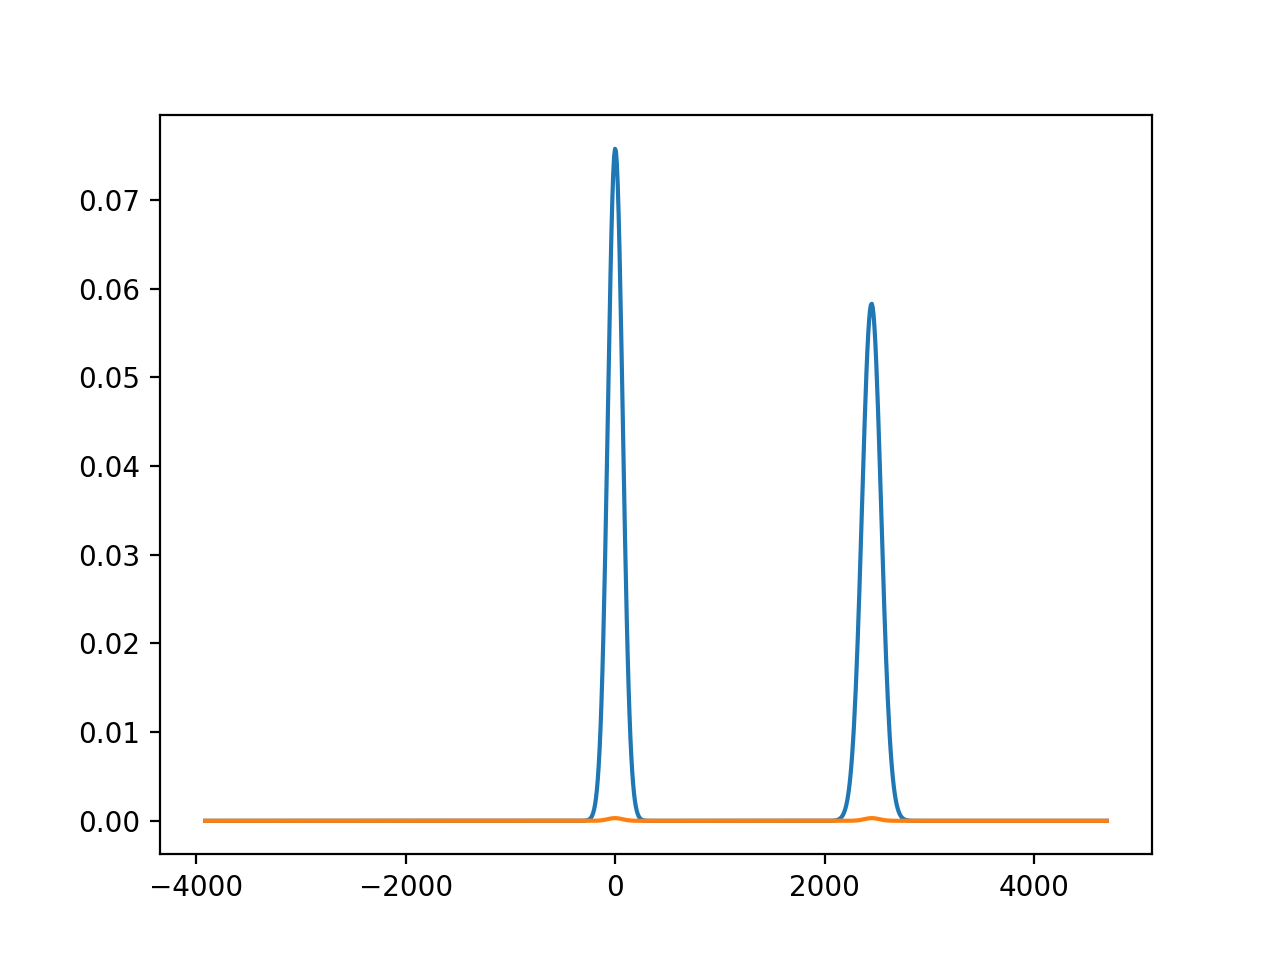

In [15]:
from spectacle.analysis.line_finder import LineFinder

y = spectrum.optical_depth(wavelength)

# nspec = Spectrum1D()
# nspec = nspec.from_data(wavelength, spectrum.tau(wavelength), smooth=False)
nspec = LineFinder(center=spectrum.center, z=spectrum.redshift)
# print(nspec)

# print(nspec(velocity, tau_spec(velocity)))
# print(nspec)
fitter = LevMarLSQFitter()
fit_nspec = fitter(nspec, wavelength, y, y)

# for pn in fit_nspec.result_model.param_names:
#     print(getattr(fit_nspec.result_model, pn))

# print(fit_nspec)

# f, ax = plt.subplots()

# # ax.plot(wavelength, spectrum.flux(wavelength))
# ax.plot(wavelength, nspec(wavelength))
print(fit_nspec.result_model)

In [ ]:

print("{:g}".format(fit_nspec.result_model.optical_depth[2].column_density.value))
f, ax = plt.subplots()

# ax.plot(wavelength, spectrum.optical_depth(wavelength))
# ax.plot(wavelength, fit_nspec.result_model(wavelength))

In [ ]:
from astropy.modeling import models, Fittable1DModel, Parameter
from astropy.modeling import fitting
import astropy.units as u
import astropy.constants as const

from spectacle.core.spectrum import Spectrum1D
from spectacle.modeling.custom import Masker
from spectacle.io.registries import line_registry

import numpy as np
import matplotlib.pyplot as plt
from spectacle.modeling.fitters import MCMCFitter
import numpy as np

velocity = np.linspace(-800, 800, 1000) * u.Unit("km/s")

line = line_registry.with_name('HI1215')

spectrum = Spectrum1D(center=line['wave']).add_line(name="HI1216", 
                                                    v_doppler=1.5e6 * u.Unit('cm/s'),
                                                    column_density=1e15 * u.Unit('1/cm2'))

y = spectrum.optical_depth(velocity) + np.random.sample(size=velocity.size) * 0.15 - 0.075

# fitter = MCMCFitter()
# fitter(spectrum.optical_depth, velocity.data, y)

In [ ]:
%matplotlib notebook

In [ ]:
from spectacle.analysis.line_finder import LineFinder

# line_finder = LineFinder()
# line_finder(velocity, y)

# print(line_finder.result_model)

f, ax = plt.subplots()

ax.plot(velocity, y)
# ax.plot(velocity, line_finder.result_model(velocity))

In [ ]:
spectrum2 = Spectrum1D(center=line['wave']).add_line(name="HI1216", 
                                                     v_doppler=1.5e7 * u.Unit('cm/s'),
                                                     column_density=1e15 * u.Unit('1/cm2'),
                                                     fixed={'column_density': False,
                                                            'delta_lambda': False})

from astropy.modeling.fitting import LevMarLSQFitter

fitter = LevMarLSQFitter()
res_fit = fitter(spectrum2.optical_depth, velocity, y)

# print(list(zip(res_fit.param_names, res_fit.parameters)))
# print(res_fit.fixed)
# print(res_fit)

f, ax = plt.subplots()

ax.plot(velocity, y)
ax.plot(velocity, res_fit(velocity))
ax.plot(velocity, spectrum2.optical_depth(velocity))

In [ ]:
import astropy
print(astropy.__version__)